In [0]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Initialize Spark session
spark = SparkSession.builder \
    .appName("ProjetElectoral") \
    .config("spark.master", "local[*]") \
    .getOrCreate()

# Set the Azure storage account key directly in the Spark session configuration
spark.conf.set("fs.azure.account.key.stockageprojet2024.dfs.core.windows.net", "IiP+e9o9Rt6mOadrgoB8rzlsOu2AHn3lSFaPDEiYMyQZ0msQs6aRJLu+zmDk09YwqL9MjHGU3BDO+AStWebm9A==")

# Define the paths to the CSV files
csv_files = {
    "data24": "abfss://staging@stockageprojet2024.dfs.core.windows.net/election-europeene-paris-2024.csv",
    "data14": "abfss://staging@stockageprojet2024.dfs.core.windows.net/elections-europeennes-2014.csv",
    "data19": "abfss://staging@stockageprojet2024.dfs.core.windows.net/elections-europeennes-2019-Paris.csv"
}

# Read the CSV files with the correct delimiter and infer schema
dataframes = {
    name: spark.read.option("header", "true").option("sep", ";").option("inferSchema", "true").csv(path)
    for name, path in csv_files.items()
}

# Verify the schema to ensure columns are read correctly
for name, df in dataframes.items():
    print(f"Schema of {name}:")
    df.printSchema()
    df.show(5, truncate=False)


Schema of data24:
root
 |-- objectid: integer (nullable = true)
 |-- id_bv: string (nullable = true)
 |-- scrutin: string (nullable = true)
 |-- annee: integer (nullable = true)
 |-- tour: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- num_circ: integer (nullable = true)
 |-- num_quartier: integer (nullable = true)
 |-- num_arrond: integer (nullable = true)
 |-- num_bureau: integer (nullable = true)
 |-- nb_procu: integer (nullable = true)
 |-- nb_inscr: integer (nullable = true)
 |-- nb_emarg: integer (nullable = true)
 |-- nb_votant: integer (nullable = true)
 |-- nb_bl: integer (nullable = true)
 |-- nb_nul: integer (nullable = true)
 |-- nb_exprim: integer (nullable = true)
 |-- deher_lesaint_leopold_edouard: integer (nullable = true)
 |-- ponge_philippe: integer (nullable = true)
 |-- marechal_marion: integer (nullable = true)
 |-- aubry_manon: integer (nullable = true)
 |-- bardella_jordan: integer (nullable = true)
 |-- toussaint_marie: integer (nullable = tr

In [0]:

# Function to clean and transform dataframes
def clean_and_transform(df):
    # Drop rows with any null values
    df = df.dropna()

    # Convert columns to appropriate data types (example)
    df = df.withColumn("column1", F.col("column1").cast(IntegerType()))
    df = df.withColumn("column2", F.col("column2").cast(DoubleType()))
    df = df.withColumn("date_column", F.to_date(F.col("date_column"), 'dd/MM/yyyy'))

    # Calculate new columns if necessary (example: vote percentage)
    if "total_votes" in df.columns and "valid_votes" in df.columns:
        df = df.withColumn("vote_percentage", (F.col("valid_votes") / F.col("total_votes")) * 100)

    # Filter out rows based on conditions (example: valid votes > 0)
    df = df.filter(F.col("valid_votes") > 0)

    return df


In [0]:

# Read the CSV files with the correct delimiter and infer schema
dataframes = {
    name: spark.read.option("header", "true").option("sep", ";").option("inferSchema", "true").csv(path)
    for name, path in csv_files.items()
}

# Function to rename columns to simpler names
def rename_columns(df):
    for col in df.columns:
        new_col = col.replace(';', '_').replace(' ', '_').replace('/', '_').replace('\\', '_').replace('-', '_')
        df = df.withColumnRenamed(col, new_col)
    return df

# Rename columns for all dataframes
dataframes = {name: rename_columns(df) for name, df in dataframes.items()}

# Fill missing values or drop rows/columns with missing values
for name, df in dataframes.items():
    if 'nb_votant' in df.columns:
        df = df.fillna({'nb_votant': 0})
    if 'date' in df.columns:
        df = df.dropna(subset=['date'])
    if 'NB_VOTANT' in df.columns:
        df = df.fillna({'NB_VOTANT': 0})
    if 'DATE' in df.columns:
        df = df.dropna(subset=['DATE'])
    dataframes[name] = df

# Verify the cleaned data
for name, df in dataframes.items():
    print(f"Cleaned schema of {name}:")
    df.printSchema()
    df.show(5, truncate=False)

    # Optionally, write the cleaned data back to storage
    df.write.mode("overwrite").option("header", "true").csv(f"abfss://staging@stockageprojet2024.dfs.core.windows.net/cleaned_{name}.csv")

# Display dataframes
display(dataframes["data24"])
display(dataframes["data14"])
display(dataframes["data19"])


Cleaned schema of data24:
root
 |-- objectid: integer (nullable = true)
 |-- id_bv: string (nullable = true)
 |-- scrutin: string (nullable = true)
 |-- annee: integer (nullable = true)
 |-- tour: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- num_circ: integer (nullable = true)
 |-- num_quartier: integer (nullable = true)
 |-- num_arrond: integer (nullable = true)
 |-- num_bureau: integer (nullable = true)
 |-- nb_procu: integer (nullable = true)
 |-- nb_inscr: integer (nullable = true)
 |-- nb_emarg: integer (nullable = true)
 |-- nb_votant: integer (nullable = false)
 |-- nb_bl: integer (nullable = true)
 |-- nb_nul: integer (nullable = true)
 |-- nb_exprim: integer (nullable = true)
 |-- deher_lesaint_leopold_edouard: integer (nullable = true)
 |-- ponge_philippe: integer (nullable = true)
 |-- marechal_marion: integer (nullable = true)
 |-- aubry_manon: integer (nullable = true)
 |-- bardella_jordan: integer (nullable = true)
 |-- toussaint_marie: integer (null

objectid id_bv scrutin annee tour date num_circ num_quartier num_arrond num_bureau nb_procu nb_inscr nb_emarg nb_votant nb_bl nb_nul nb_exprim deher_lesaint_leopold_edouard ponge_philippe marechal_marion aubry_manon bardella_jordan toussaint_marie azergui_nagib thouy_helene terrien_olivier zorn_caroline hayer_valerie alexandre_audric cholley_marine wehrling_yann asselineau_francois simonin_michel fortane_jean_marc bellamy_francois_xavier arthaud_nathalie larrouturou_pierre renard_kuzmanovic_georges labib_selma adoue_camille philippot_florian husson_edouard bonneau_pierre_marie glucksmann_raphael hoareau_charles lassalle_jean lalanne_francis lacroix_guillaume elmayan_lorys deffontaines_leon coste_meunier_gael governatori_jean_marc traore_hamada patas_d_illiers_laure grude_patrice st_area_shape st_perimeter_shape geo_shape geo_point_2d 19 2-19 Européennes 2024 1 09/06/2024 1 8 2 19 90 1799 1028 1028 2 3 1023 0 0 35 149 53 163 0 17 0 7 218 1 5 1 5 0 0 49 1 3 0 1 0 5 0 0 286 0 1 0 5 0 10 0 8 0 0 0 62855.12252708704 1145.0549504958071 "{""coordinates"": [[[2.3526689192051538, 48.86968602156442], [2.352612789226425, 48.86959990740869], [2.352513202780265, 48.86945904371158], [2.352408530313291, 48.86930010442136], [2.3524036671917323, 48.86929322513228], [2.352396820807641, 48.86928862573354], [2.3475933908115856, 48.86784179481116], [2.3473664279821786, 48.86783510384115], [2.3477106439321638, 48.8685480676492], [2.347745736726978, 48.868801837302286], [2.347875071659924, 48.86994561550211], [2.3478870044339017, 48.87026980107006], [2.347880282483183, 48.870704148509446], [2.350960685459888, 48.870049489907146], [2.352631014364641, 48.86969449879282], [2.3526689192051538, 48.86968602156442]]], ""type"": ""Polygon""}" 48.86935106766877, 2.3495380877592735 27 3-27 Européennes 2024 1 09/06/2024 5 11 3 27 73 1509 989 990 5 4 981 0 0 73 112 53 98 0 8 0 4 215 0 4 4 7 0 0 106 0 0 0 2 1 6 0 0 277 0 2 1 0 0 2 0 6 0 0 0 74400.56394547594 1380.5287627634991 "{""coordinates"": [[[2.367846748453271, 48.85851128288139], [2.36806857045761, 48.857586670498634], [2.368102887802647, 48.857443425345885], [2.3681697704506983, 48.85716424820899], [2.368202012817156, 48.85702965994913], [2.368227316702227, 48.85692403905225], [2.368227736005118, 48.85692228033982], [2.3684797205288945, 48.855830810456254], [2.3672044518170936, 48.85603990296715], [2.367206118827503, 48.8560470715099], [2.3672429120449667, 48.85685668997732], [2.3672331435187512, 48.856865585951304], [2.3645929212951033, 48.8573792951972], [2.364583263820953, 48.85738909808745], [2.3645759723148956, 48.85744026022779], [2.3645977388849047, 48.85754909634542], [2.3646192810854987, 48.8575669207152], [2.364622136970262, 48.85757135078446], [2.3647162686946053, 48.858042014940665], [2.364706019667277, 48.85805192351626], [2.364473663298848, 48.858089724167264], [2.364464749505167, 48.85809441549602], [2.363460522841397, 48.85942206868634], [2.363454869758115, 48.85943707571216], [2.363478295381188, 48.8594460274149], [2.364524581395425, 48.85942028357141], [2.364538710656489, 48.859428969855614], [2.36456450926429, 48.85993826435455], [2.364585908085008, 48.8599453497186], [2.36758071690501, 48.85857224254041], [2.367846748453271, 48.85851128288139]]], ""type"": ""Polygon""}" 48.858016352562466, 2.366192505885034 67 5-17 Européennes 2024 1 09/06/2024 2 18 5 17 84 1446 964 964 2 7 955 0 0 47 124 69 116 0 16 0 8 156 0 4 2 18 0 0 91 3 0 0 1 0 6 0 0 274 0 5 0 2 0 9 0 4 0 0 0 58501.54599587247 992.2093332445282 "{""coordinates"": [[[2.3532420348292433, 48.838916247813174], [2.3532512730004624, 48.83889182063421], [2.354274581748154, 48.83775214075807], [2.354402473674015, 48.83760035433483], [2.3527209048408593, 48.83706260185904], [2.3518692624711504, 48.836796258275825], [2.351844303854664, 48.83678874372697], [2.3518184269230042, 48.836782767510634], [2.351791817719378, 48.83677837830095], [2.351764704619607, 48.836775616907225], [2.351761630802457, 48.836775414979336], [2.3516626011261312, 4

ID_BVOTE SCRUTIN ANNEE TOUR DATE NUM_CIRC NUM_QUARTIER NUM_ARROND NUM_BUREAU NB_PROCU NB_INSCR NB_EMARG NB_VOTANT NB_BL NB_NUL NB_EXPRIM Vincent_LE_SCORNET Isabelle_BORDRY Balié_TOPLA Pascal_DURAND Julien_VOLGANLI Farid_GHEIOUECHE Alain_LAMASSOURE Hélène_FEO Christophe_PAILLARD Francis_MBELLA Marielle_DE_SARNEZ Laure_PATAS_D'ILLIERS Jean_GRIMAL Dominique_JAMET Stéphane_GUYOT Caroline_DE_HAAS Jean_Marc_GOVERNATORI Pervenche_BERÈS Patrick_LE_HYARIC Antoine_MAYEROWITZ Magali_LEPAPE François_ASSELINEAU Gaspard_DELANOË Nathalie_ARTHAUD Véronique_VERMOREL Pierre_LARROUTUROU Corinne_LEPAGE Louis_DE_GOUYON_MATIGNON_DE_PON Christine_BOUTIN Aymeric_CHAUPRADE Olivier_BESANCENOT Geo_Shape geo_point_2d 1-10 Européennes 2014 1 2014-05-26 1 4 1 10 21 823 426 426 5 2 419 0 17 0 28 0 1 175 0 0 2 45 0 0 8 0 1 9 57 8 0 0 0 0 0 4 7 6 1 9 41 0 "{""coordinates"": [[[2.3279665917, 48.8699083635], [2.3299571376, 48.8684686309], [2.3299704035, 48.8684860785], [2.3305562437, 48.8682133196], [2.330694088, 48.868145129], [2.3308149037, 48.8656728147], [2.3300348345, 48.8647980499], [2.3301083722, 48.8644384699], [2.3235822412, 48.8665242729], [2.3253281543, 48.8690052985], [2.3251951376, 48.8694274667], [2.3279665917, 48.8699083635]]], ""type"": ""Polygon""}" 48.8672573027, 2.3276516173 4-11 Européennes 2014 1 2014-05-26 7 13 4 11 20 993 506 506 3 1 502 0 12 0 89 0 1 115 0 0 0 58 1 0 9 0 3 6 113 17 0 0 3 0 0 0 27 9 0 1 34 4 "{""coordinates"": [[[2.3468751541, 48.856726268], [2.347060172, 48.8570277804], [2.3475770294, 48.8573113153], [2.3488505288, 48.859605681], [2.3494706698, 48.859404597], [2.3495304864, 48.8593004913], [2.3502104581, 48.8590814488], [2.3502648476, 48.8590347777], [2.3505150849, 48.8589880834], [2.3512439759, 48.858650572], [2.3515540466, 48.85858592], [2.3530227128, 48.8580365135], [2.3523587934, 48.857287808], [2.353658827, 48.8568963588], [2.3524504869, 48.8547179831], [2.3499484874, 48.8557951772], [2.3468751541, 48.856726268]]], ""type"": ""Polygon""}" 48.8571618742, 2.35045186188 5-11 Européennes 2014 1 2014-05-26 2 19 5 11 48 1382 875 875 8 4 863 0 16 2 109 1 1 170 0 0 1 142 0 0 16 2 5 7 189 54 0 0 5 0 0 3 28 32 0 9 66 5 "{""coordinates"": [[[2.3432039422, 48.8411032238], [2.3457550109, 48.8401535622], [2.3459675243, 48.8401381414], [2.3458184087, 48.8392368325], [2.3485241594, 48.8390061045], [2.349216793, 48.8389519549], [2.3489495079, 48.8371204856], [2.3471139207, 48.8373511188], [2.3407311549, 48.8387009733], [2.3408402487, 48.8389886627], [2.3432039422, 48.8411032238]]], ""type"": ""Polygon""}" 48.8389287477, 2.34502715245 5-23 Européennes 2014 1 2014-05-26 2 17 5 23 42 1374 792 795 12 2 781 0 24 1 94 0 4 177 0 0 0 99 0 0 21 1 1 11 142 35 0 1 3 0 6 3 33 22 2 20 77 4 "{""coordinates"": [[[2.3498567794, 48.8520218521], [2.3502251249, 48.8519078665], [2.3516806991, 48.851530674], [2.3524515196, 48.8513611031], [2.35290551, 48.8513001818], [2.3526184556, 48.85070396], [2.3505846297, 48.8497782179], [2.3498909414, 48.8488257298], [2.3505625149, 48.8480045181], [2.3485545724, 48.8473891742], [2.3484992462, 48.847501764], [2.3485483778, 48.847808128], [2.3485032529, 48.8485307985], [2.349017567, 48.8497127992], [2.3487245413, 48.8501604267], [2.3487824552, 48.8503419178], [2.3493055587, 48.8513526323], [2.3498567794, 48.8520218521]]], ""type"": ""Polygon""}" 48.850023688, 2.35016479763 6-4 Européennes 2014 1 2014-05-26 2 21 6 4 24 1038 549 549 5 2 542 0 12 0 68 0 0 134 0 0 0 81 1 0 18 2 1 7 112 15 0 0 3 0 1 3 16 15 0 2 46 5 "{""coordinates"": [[[2.3366138529, 48.8585403883], [2.3374860276, 48.8583195484], [2.3407894221, 48.856497008], [2.342520574, 48.8549840737], [2.3427546759, 48.8548487419], [2.342132315, 48.854190377], [2.3406386706, 48.8543019315], [2.3403108736, 48.8542395011], [2.3393579201, 48.8544937421], [2.3394390467, 48.8549977186], [2.3379878268, 48.8551625596], [2.3376615082, 48.8553768379], [2.3367693509, 48.8554102879], [2.3365220259, 48.8571731601], [2.3364889596, 48.8573476998], [2.3363603741, 48.8575246625], [

id_bvote scrutin annee tour date num_circ num_quartier num_arrond num_bureau nb_procu nb_inscr nb_emarg nb_votant nb_bl nb_nul nb_exprim aubry_manon de_prevoisin_robert camus_renaud marie_florie loiseau_nathalie traore_hamada philippot_florian alexandre_audric bourg_dominique vauclin_vincent lagarde_jean_christophe glucksmann_raphael gernigon_yves helgen_gilles dupont_aignan_nicolas caillaud_sophie delfel_therese arthaud_nathalie brossat_ian asselineau_francois hamon_benoit tomasini_nathalie bardella_jordan corbet_cathy_denise_ginette sanchez_antonio dieumegard_pierre chalencon_christophe lalanne_francis bellamy_francois_xavier jadot_yannick thouy_helene bidou_olivier person_christian_luc azergui_najib geo_shape geo_point_2d 1-5 Européennes 2019 1 2019-05-26 1 2 1 5 29 1059 626 626 1 1 624 16 0 0 4 257 0 1 0 24 0 4 62 0 0 3 0 0 1 14 2 20 1 45 0 0 0 0 0 49 113 8 0 0 0 "{""coordinates"": [[[2.3418080502, 48.8655698941], [2.3477253083, 48.8641606558], [2.347679809, 48.86370214], [2.3465936476, 48.8634487878], [2.3461238969, 48.8631751376], [2.3449113805, 48.861790434], [2.3446934996, 48.8618611413], [2.3439641638, 48.8633750668], [2.3427999242, 48.8637026271], [2.3417975767, 48.8641231205], [2.3406918797, 48.8646517874], [2.3418080502, 48.8655698941]]], ""type"": ""Polygon""}" 48.8640196095, 2.34427349887 3-11 Européennes 2019 1 2019-05-26 1 12 3 11 57 1535 937 937 6 5 926 38 0 0 4 382 0 1 1 18 0 11 69 0 0 8 0 1 5 29 3 35 0 41 0 0 0 0 1 50 216 12 1 0 0 "{""coordinates"": [[[2.3554636259, 48.8629603048], [2.3573142193, 48.8624214385], [2.3581261147, 48.8633844374], [2.3582475325, 48.8633595512], [2.3587582705, 48.8631356831], [2.3597545693, 48.8626009236], [2.3582508325, 48.8612823622], [2.3568879089, 48.8601002275], [2.3535387599, 48.8612265309], [2.3548118176, 48.8618139354], [2.3545860195, 48.8626689921], [2.3554636259, 48.8629603048]]], ""type"": ""Polygon""}" 48.8617663843, 2.35670816193 3-12 Européennes 2019 1 2019-05-26 1 9 3 12 38 1401 781 781 7 11 763 50 0 0 5 264 0 3 0 10 0 11 71 0 0 3 1 1 3 26 6 36 0 32 0 1 0 0 4 42 181 13 0 0 0 "{""coordinates"": [[[2.3575198541, 48.8651359918], [2.3595478397, 48.864699702], [2.359359319, 48.864493651], [2.3588273257, 48.8640158291], [2.3584126108, 48.8635998645], [2.3582492239, 48.8633982269], [2.3567478801, 48.8638515676], [2.3532853138, 48.8648364625], [2.3561501596, 48.8654213042], [2.3575198541, 48.8651359918]]], ""type"": ""Polygon""}" 48.8645397569, 2.35679837016 4-7 Européennes 2019 1 2019-05-26 7 15 4 7 59 1321 848 848 6 3 839 20 0 0 4 319 0 3 1 21 0 15 80 0 0 13 1 0 0 27 3 19 0 52 0 0 0 0 1 83 166 10 1 0 0 "{""coordinates"": [[[2.3658774291, 48.8534321182], [2.3664182295, 48.8533479701], [2.3676407463, 48.8532248834], [2.3690294475, 48.8530081645], [2.3680633104, 48.8509085344], [2.3668572771, 48.8508240779], [2.3661562149, 48.8496602637], [2.3652155797, 48.8498207728], [2.3660655485, 48.8505261756], [2.3668394896, 48.8515701796], [2.3630736664, 48.8510178373], [2.36265937, 48.8512722843], [2.3629537482, 48.8515265675], [2.3637453982, 48.8516850085], [2.3642142181, 48.8526175167], [2.3655497327, 48.8529399096], [2.3658774291, 48.8534321182]]], ""type"": ""Polygon""}" 48.851941217, 2.36628775415 4-14 Européennes 2019 1 2019-05-26 7 14 4 14 41 1180 740 740 6 4 730 31 0 0 0 263 0 3 0 13 0 12 76 1 0 6 0 0 4 28 7 30 0 39 0 0 0 0 0 55 150 12 0 0 0 "{""coordinates"": [[[2.3568201484, 48.8566158386], [2.3578759714, 48.8578668995], [2.3588066798, 48.857500472], [2.3589858646, 48.8573897992], [2.3593326716, 48.8571722704], [2.3612517341, 48.8562142818], [2.3611473028, 48.8554676912], [2.3602165909, 48.8557082393], [2.3601182019, 48.855486984], [2.3566500365, 48.8563233475], [2.3568201484, 48.8566158386]]], ""type"": ""Polygon""}" 48.8565248941, 2.35892341375 6-8 Européennes 2019 1 2019-05-26 11 24 6 8 25 997 618 618 4 5 609 15 0 0 3 280 0 2 0 7 0 9 28 1 0 4 0 0 2 12 6 16 0 30 0 0 0 0 0 89 100 4 1 0 0 "{""coordinates"": [[[2.3317020447, 48.8563070327], [2.3333125017, 48.8582729807], [2.

In [0]:

# Function to rename columns to simpler names
def rename_columns(df):
    for col in df.columns:
        new_col = col.replace(';', '_').replace(' ', '_').replace('/', '_').replace('\\', '_').replace('-', '_')
        df = df.withColumnRenamed(col, new_col)
    return df

# Rename columns for all dataframes
dataframes = {name: rename_columns(df) for name, df in dataframes.items()}

# Fill missing values or drop rows/columns with missing values
for name, df in dataframes.items():
    if 'nb_votant' in df.columns:
        df = df.fillna({'nb_votant': 0})
    if 'date' in df.columns:
        df = df.dropna(subset=['date'])
    if 'NB_VOTANT' in df.columns:
        df = df.fillna({'NB_VOTANT': 0})
    if 'DATE' in df.columns:
        df = df.dropna(subset=['DATE'])
    dataframes[name] = df

# Verify the cleaned data
for name, df in dataframes.items():
    print(f"Cleaned schema of {name}:")
    df.printSchema()
    df.show(5, truncate=False)

# Cleaning process similar to your friend's project
# Example: Adding new columns and cleaning data

# Function to count null values
def count_nulls(df):
    return df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Count null values for each DataFrame
for key, df in dataframes.items():
    null_counts = count_nulls(df)
    print(f"Null values in {key} DataFrame :")
    null_counts.show(truncate=False)

# Example: Adding a new column 'total_votes' as a sum of some columns (assuming some columns exist for this example)
for name, df in dataframes.items():
    if 'nb_bl' in df.columns and 'nb_nul' in df.columns and 'nb_exprim' in df.columns:
        df = df.withColumn('total_votes', F.col('nb_bl') + F.col('nb_nul') + F.col('nb_exprim'))
        dataframes[name] = df

# Clean and fill null values in 'geo_shape' and 'geo_point_2d' columns
for name, df in dataframes.items():
    if 'geo_shape' in df.columns:
        df = df.withColumn("geo_shape", F.when(F.col("geo_shape").isNull(), "unknown").otherwise(F.col("geo_shape")))
    if 'geo_point_2d' in df.columns:
        df = df.withColumn("geo_point_2d", F.when(F.col("geo_point_2d").isNull(), "unknown").otherwise(F.col("geo_point_2d")))
    dataframes[name] = df

# Write cleaned DataFrames to Parquet
output_path = {
    "data24": "abfss://staging@stockageprojet2024.dfs.core.windows.net/cleaned_data/data24",
    "data14": "abfss://staging@stockageprojet2024.dfs.core.windows.net/cleaned_data/data14",
    "data19": "abfss://staging@stockageprojet2024.dfs.core.windows.net/cleaned_data/data19"
}

# Write the DataFrames in Parquet format
for key, df in dataframes.items():
    df.write.mode("overwrite").parquet(output_path[key])


Cleaned schema of data24:
root
 |-- objectid: integer (nullable = true)
 |-- id_bv: string (nullable = true)
 |-- scrutin: string (nullable = true)
 |-- annee: integer (nullable = true)
 |-- tour: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- num_circ: integer (nullable = true)
 |-- num_quartier: integer (nullable = true)
 |-- num_arrond: integer (nullable = true)
 |-- num_bureau: integer (nullable = true)
 |-- nb_procu: integer (nullable = true)
 |-- nb_inscr: integer (nullable = true)
 |-- nb_emarg: integer (nullable = true)
 |-- nb_votant: integer (nullable = false)
 |-- nb_bl: integer (nullable = true)
 |-- nb_nul: integer (nullable = true)
 |-- nb_exprim: integer (nullable = true)
 |-- deher_lesaint_leopold_edouard: integer (nullable = true)
 |-- ponge_philippe: integer (nullable = true)
 |-- marechal_marion: integer (nullable = true)
 |-- aubry_manon: integer (nullable = true)
 |-- bardella_jordan: integer (nullable = true)
 |-- toussaint_marie: integer (null

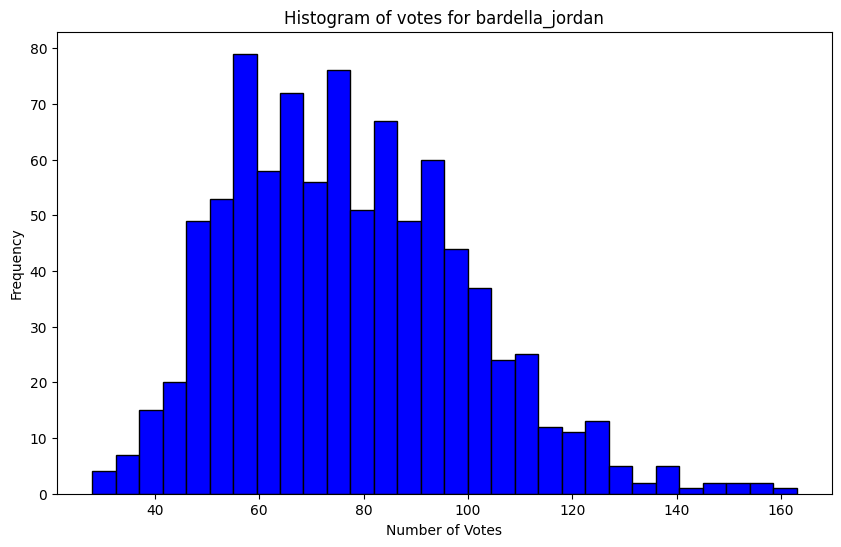

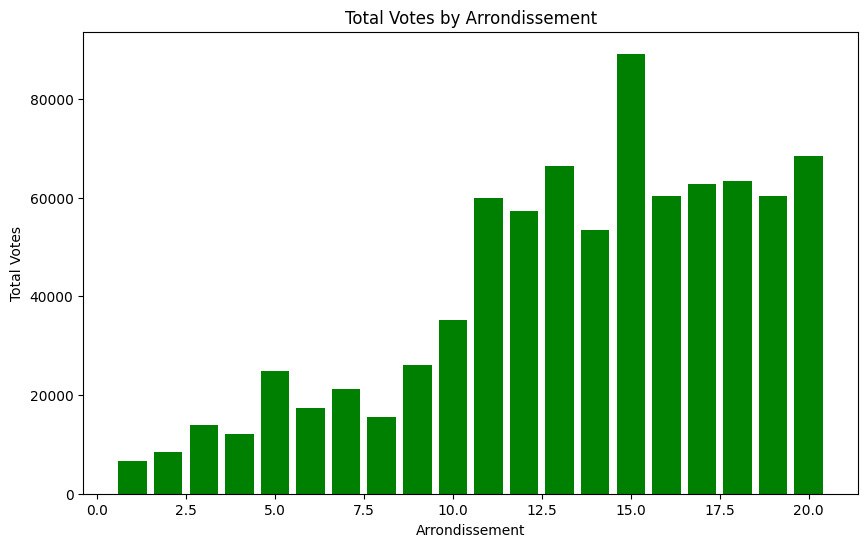

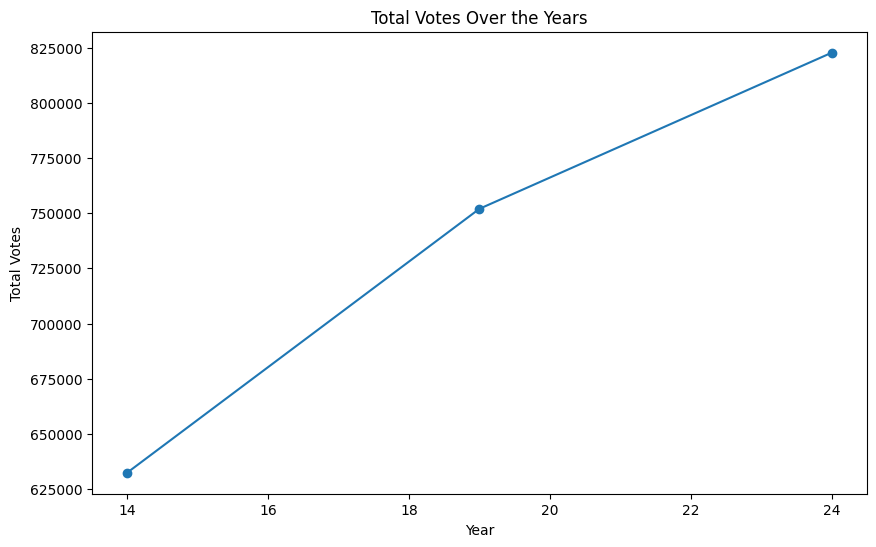

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Exemple de création de plots avec matplotlib

# Convertir un DataFrame Spark en Pandas DataFrame
def convert_to_pandas(spark_df):
    return spark_df.toPandas()

# Histogramme des votes pour un candidat spécifique
def plot_candidate_votes(df, candidate):
    pdf = convert_to_pandas(df.select('num_arrond', candidate))
    pdf = pdf[pdf[candidate].notnull()]  # Filter out null values
    plt.figure(figsize=(10, 6))
    plt.hist(pdf[candidate], bins=30, color='blue', edgecolor='black')
    plt.title(f'Histogram of votes for {candidate}')
    plt.xlabel('Number of Votes')
    plt.ylabel('Frequency')
    plt.show()

# Répartition des votes par arrondissement
def plot_votes_by_arrond(df):
    pdf = convert_to_pandas(df.groupBy('num_arrond').sum('nb_votant').withColumnRenamed('sum(nb_votant)', 'total_votes'))
    plt.figure(figsize=(10, 6))
    plt.bar(pdf['num_arrond'], pdf['total_votes'], color='green')
    plt.title('Total Votes by Arrondissement')
    plt.xlabel('Arrondissement')
    plt.ylabel('Total Votes')
    plt.show()

# Évolution du nombre de votants sur les années
def plot_votes_by_year(dataframes):
    votes_by_year = []
    for name, df in dataframes.items():
        year = int(name[-2:])
        total_votes = df.select(F.sum('nb_votant').alias('total_votes')).collect()[0]['total_votes']
        votes_by_year.append((year, total_votes))
    votes_by_year.sort()
    years, total_votes = zip(*votes_by_year)
    plt.figure(figsize=(10, 6))
    plt.plot(years, total_votes, marker='o')
    plt.title('Total Votes Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Total Votes')
    plt.show()

# Exemple d'utilisation des fonctions pour créer des plots
plot_candidate_votes(dataframes['data24'], 'bardella_jordan')
plot_votes_by_arrond(dataframes['data24'])
plot_votes_by_year(dataframes)


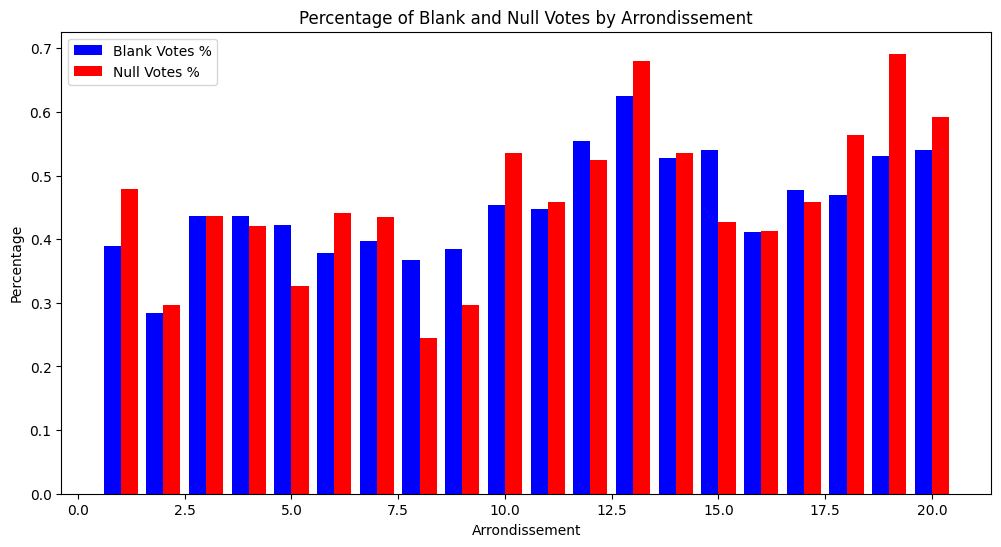

In [0]:
def plot_blank_and_null_votes_by_arrond(df):
    pdf = convert_to_pandas(df.select('num_arrond', 'nb_bl', 'nb_nul', 'nb_votant'))
    pdf = pdf.groupby('num_arrond').sum().reset_index()
    pdf['pct_blank'] = (pdf['nb_bl'] / pdf['nb_votant']) * 100
    pdf['pct_null'] = (pdf['nb_nul'] / pdf['nb_votant']) * 100
    plt.figure(figsize=(12, 6))
    plt.bar(pdf['num_arrond'] - 0.2, pdf['pct_blank'], width=0.4, label='Blank Votes %', color='blue')
    plt.bar(pdf['num_arrond'] + 0.2, pdf['pct_null'], width=0.4, label='Null Votes %', color='red')
    plt.title('Percentage of Blank and Null Votes by Arrondissement')
    plt.xlabel('Arrondissement')
    plt.ylabel('Percentage')
    plt.legend()
    plt.show()

plot_blank_and_null_votes_by_arrond(dataframes['data24'])


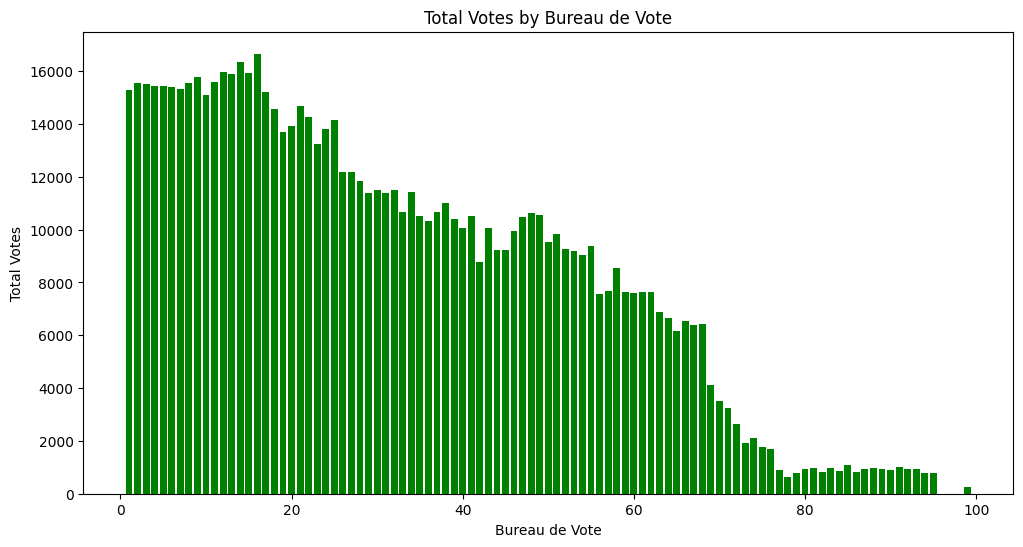

In [0]:
def plot_total_votes_by_bureau(df):
    pdf = convert_to_pandas(df.select('num_bureau', 'nb_votant'))
    pdf = pdf.groupby('num_bureau').sum().reset_index()
    plt.figure(figsize=(12, 6))
    plt.bar(pdf['num_bureau'], pdf['nb_votant'], color='green')
    plt.title('Total Votes by Bureau de Vote')
    plt.xlabel('Bureau de Vote')
    plt.ylabel('Total Votes')
    plt.show()

plot_total_votes_by_bureau(dataframes['data24'])


In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Étape 1: Préparation des données
def prepare_data(df):
    # Sélectionner les colonnes pertinentes
    df = df.select('nb_exprim', 'nb_votant', 'nb_inscr').dropna()

    # Créer une colonne features qui contient les features sous forme de vecteur
    assembler = VectorAssembler(inputCols=['nb_votant', 'nb_inscr'], outputCol='features')
    df = assembler.transform(df)
    return df

data = prepare_data(dataframes['data24'])

# Étape 2: Création et entraînement du modèle
lr = LinearRegression(featuresCol='features', labelCol='nb_exprim')

# Diviser les données en training et test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Entraîner le modèle
lr_model = lr.fit(train_data)

# Étape 3: Évaluation du modèle
predictions = lr_model.transform(test_data)

# Évaluer les performances du modèle
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='nb_exprim', metricName='rmse')
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2: {r2}")

# Étape 4: Affichage des résultats
predictions.select("nb_exprim", "prediction", "features").show(5)

# Optionnel: Afficher les coefficients et l'intercept
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")


Root Mean Squared Error (RMSE): 4.010329169315168
R2: 0.9993138084143484
+---------+------------------+--------------+
|nb_exprim|        prediction|      features|
+---------+------------------+--------------+
|      336|332.52317634132174| [340.0,760.0]|
|      428|437.52681861119623|[449.0,1203.0]|
|      551| 554.0257414754984|[565.0,1291.0]|
|      563| 557.2849370579889|[570.0,1437.0]|
|      573| 569.1295950530903|[586.0,1790.0]|
+---------+------------------+--------------+
only showing top 5 rows

Coefficients: [1.0137023234074294,-0.012392575579086476]
Intercept: -2.7172561770985424
